In [18]:
import pandas as pd

qualifying_results = pd.read_csv("2024_data/2024_qualifying_results.csv")
race_results = pd.read_csv("2024_data/2024_race_results.csv")
qualifying_results.head()
# race_results.head()

,Track,Position,No,Driver,Team,Q1,Q2,Q3,Laps
0,Bahrain,1,1,Max Verstappen,Red Bull Racing Honda RBPT,1:30.031,1:29.374,1:29.179,17
1,Bahrain,2,16,Charles Leclerc,Ferrari,1:30.243,1:29.165,1:29.407,19
2,Bahrain,3,63,George Russell,Mercedes,1:30.350,1:29.922,1:29.485,17
3,Bahrain,4,55,Carlos Sainz,Ferrari,1:29.909,1:29.573,1:29.507,18
4,Bahrain,5,11,Sergio Perez,Red Bull Racing Honda RBPT,1:30.221,1:29.932,1:29.537,17


In [19]:
import pandas as pd

# Rename columns
race_results.rename(columns={
    'Track': 'track',
    'Position': 'position',
    'No': 'car_number',
    'Driver': 'driver',
    'Team': 'team',
    'Starting Grid': 'starting_grid',
    'Laps': 'laps',
    'Time/Retired': 'time_retired',
    'Points': 'points',
    'Set Fastest Lap': 'set_fastest_lap',
    'Fastest Lap Time': 'fastest_lap_time'
}, inplace=True)

# Handling missing values in 'fastest_lap_time'
# Fill missing values with 'N/A'
race_results['fastest_lap_time'].fillna('N/A', inplace=True)

# Display the cleaned dataframe
print(race_results.head())
print(race_results.info())
print(race_results.isnull().sum())


     track position  car_number           driver                        team  \
0  Bahrain        1           1   Max Verstappen  Red Bull Racing Honda RBPT   
1  Bahrain        2          11     Sergio Perez  Red Bull Racing Honda RBPT   
2  Bahrain        3          55     Carlos Sainz                     Ferrari   
3  Bahrain        4          16  Charles Leclerc                     Ferrari   
4  Bahrain        5          63   George Russell                    Mercedes   

   starting_grid  laps time_retired  points set_fastest_lap fastest_lap_time  
0              1    57  1:31:44.742      26             Yes         1:32.608  
1              5    57      +22.457      18              No         1:34.364  
2              4    57      +25.110      15              No         1:34.507  
3              2    57      +39.669      12              No         1:34.090  
4              3    57      +46.788      10              No         1:35.065  
<class 'pandas.core.frame.DataFrame'>
RangeIn

In [20]:
import pandas as pd

# Load the dataset

# Convert 'position' to numerical (if not already done)
if race_results['position'].dtype == 'object':
    race_results['position'] = race_results['position'].replace(['NC', 'DNF'], 99)
    race_results['position'] = race_results['position'].astype(int)

# Ensure all values in 'time_retired' are strings
race_results['time_retired'] = race_results['time_retired'].astype(str)

# Create a new binary feature 'finished_race'
race_results['finished_race'] = race_results['time_retired'].apply(lambda x: 0 if 'DNF' in x or 'DNS' in x else 1)

# Handle '+1 lap', '+2 laps', etc., in 'time_retired'
def convert_time_retired(value):
    if 'DNF' in value or 'DNS' in value:
        return 0  # Non-finishers get a 0
    elif '+1 lap' in value:
        return 1
    elif '+2 laps' in value:
        return 2
    else:
        try:
            # Convert time to seconds (assuming format is h:mm:ss or m:ss)
            time_parts = value.split(':')
            if len(time_parts) == 3:  # h:mm:ss
                return int(time_parts[0]) * 3600 + int(time_parts[1]) * 60 + float(time_parts[2])
            elif len(time_parts) == 2:  # m:ss
                return int(time_parts[0]) * 60 + float(time_parts[1])
            else:
                return float(value)
        except:
            return 0

race_results['time_retired'] = race_results['time_retired'].apply(convert_time_retired)

# Handle 'fastest_lap_time' conversion to seconds
def convert_fastest_lap_time(value):
    if value == 'N/A':
        return 0
    try:
        # Convert time to seconds (assuming format is h:mm:ss or m:ss)
        time_parts = value.split(':')
        if len(time_parts) == 3:  # h:mm:ss
            return int(time_parts[0]) * 3600 + int(time_parts[1]) * 60 + float(time_parts[2])
        elif len(time_parts) == 2:  # m:ss
            return int(time_parts[0]) * 60 + float(time_parts[1])
        else:
            return float(value)
    except:
        return 0

race_results['fastest_lap_time'] = race_results['fastest_lap_time'].apply(convert_fastest_lap_time)

# Drop the 'track' column
race_results.drop(columns=['track'], inplace=True)

# Encode categorical variables (excluding track)
if not any(col.startswith('driver_') for col in race_results.columns):
    race_results = pd.get_dummies(race_results, columns=['driver', 'team', 'set_fastest_lap'], drop_first=True)

# Convert boolean columns to integers
boolean_columns = race_results.select_dtypes(include=['bool']).columns
race_results[boolean_columns] = race_results[boolean_columns].astype(int)

# Ensure all steps are completed
print(race_results.head())
race_results.to_csv("final_data.csv", index=False)


   position  car_number  starting_grid  laps  time_retired  points  \
0         1           1              1    57      5504.742      26   
1         2          11              5    57        22.457      18   
2         3          55              4    57        25.110      15   
3         4          16              2    57        39.669      12   
4         5          63              3    57        46.788      10   

   fastest_lap_time  finished_race  driver_Carlos Sainz  \
0            92.608              1                    0   
1            94.364              1                    0   
2            94.507              1                    1   
3            94.090              1                    0   
4            95.065              1                    0   

   driver_Charles Leclerc  ...  team_Aston Martin Aramco Mercedes  \
0                       0  ...                                  0   
1                       0  ...                                  0   
2                

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the cleaned and engineered dataset
file_path = 'final_data.csv'
race_results = pd.read_csv(file_path)

# Define the features and target variable
X = race_results.drop(columns=['position'])
y = race_results['position']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 7.945645833333336
R^2 Score: 0.987180484566598


In [22]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean Cross-Validation R^2 Score: {cv_scores.mean()}")


Cross-Validation R^2 Scores: [0.99276887 0.81392944 0.99485347 0.9606864  0.88243568]
Mean Cross-Validation R^2 Score: 0.92893477328138


Feature ranking:
1. feature finished_race (0.47269361962601436)
2. feature time_retired (0.3593536384427137)
3. feature laps (0.1218880075777581)
4. feature points (0.03241722330728564)
5. feature driver_George Russell (0.0036264294508456234)
6. feature team_Mercedes (0.0028997137365688627)
7. feature starting_grid (0.0028478988057608614)
8. feature car_number (0.0020940927435709918)
9. feature team_Williams Mercedes (0.0005506271731581013)
10. feature fastest_lap_time (0.000522520916862834)
11. feature driver_Carlos Sainz (0.0005119342974783113)
12. feature team_Haas Ferrari (9.131078917286991e-05)
13. feature driver_Nico Hulkenberg (7.66628729027956e-05)
14. feature team_Kick Sauber Ferrari (6.65248207584745e-05)
15. feature driver_Yuki Tsunoda (5.948281360335634e-05)
16. feature driver_Valtteri Bottas (5.0117027478299206e-05)
17. feature driver_Daniel Ricciardo (4.0580416407296984e-05)
18. feature driver_Lance Stroll (3.5349557806050715e-05)
19. feature team_Aston Martin Aramco Merc

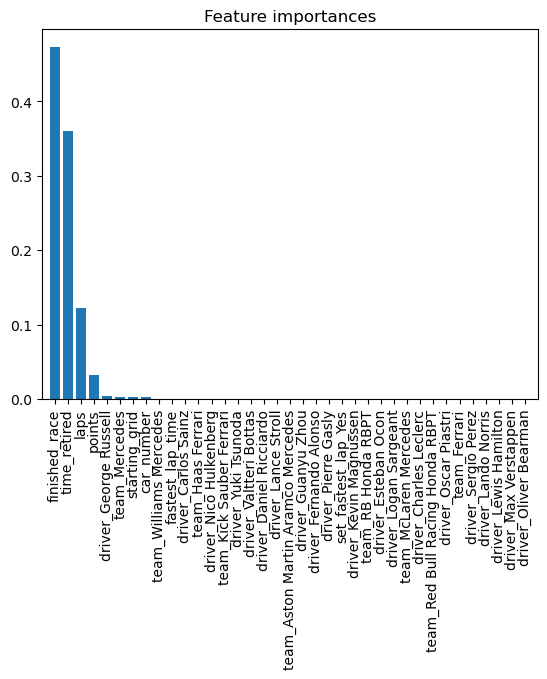

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances of the model
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


In [25]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation R^2 Score: {grid_search.best_score_}")

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions with the best model
best_y_pred = best_model.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test, best_y_pred)
best_r2 = r2_score(y_test, best_y_pred)

print(f"Best Model Mean Squared Error: {best_mse}")
print(f"Best Model R^2 Score: {best_r2}")


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation R^2 Score: 0.9431721940427182
Best Model Mean Squared Error: 8.409799232218532
Best Model R^2 Score: 0.9864316188626281


Mean Squared Error: 10.849766676351928
R^2 Score: 0.9824949721805113


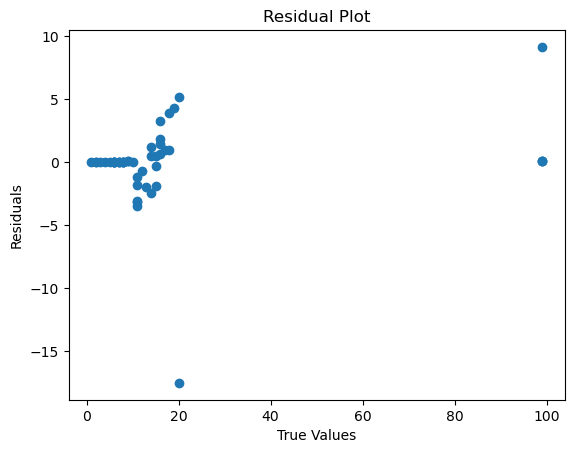

In [55]:
# Select features with non-zero importance
important_features = [feature for feature, importance in zip(X.columns, model.feature_importances_) if importance > 0]

# Update X to include only important features
X_important = X[important_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

# Initialize and train the model with the best parameters found
best_model = RandomForestRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot residuals
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test - y_pred)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [28]:
# Identify and analyze outliers
residuals = y_test - y_pred
outliers = X_test[abs(residuals) > 10]
print(outliers)

# Investigate if these outliers have any common characteristics
outlier_summary = outliers.describe()
print(outlier_summary)

     car_number  starting_grid  laps  time_retired  points  fastest_lap_time  \
218           4              2    64           0.0       0            68.016   

     finished_race  driver_Carlos Sainz  driver_Charles Leclerc  \
218              1                    0                       0   

     driver_Daniel Ricciardo  ...  team_Aston Martin Aramco Mercedes  \
218                        0  ...                                  0   

     team_Ferrari  team_Haas Ferrari  team_Kick Sauber Ferrari  \
218             0                  0                         0   

     team_McLaren Mercedes  team_Mercedes  team_RB Honda RBPT  \
218                      1              0                   0   

     team_Red Bull Racing Honda RBPT  team_Williams Mercedes  \
218                                0                       0   

     set_fastest_lap_Yes  
218                    0  

[1 rows x 33 columns]
       car_number  starting_grid  laps  time_retired  points  \
count         1.0        

Mean Squared Error: 2.9573840356264367
R^2 Score: 0.9843917140996509


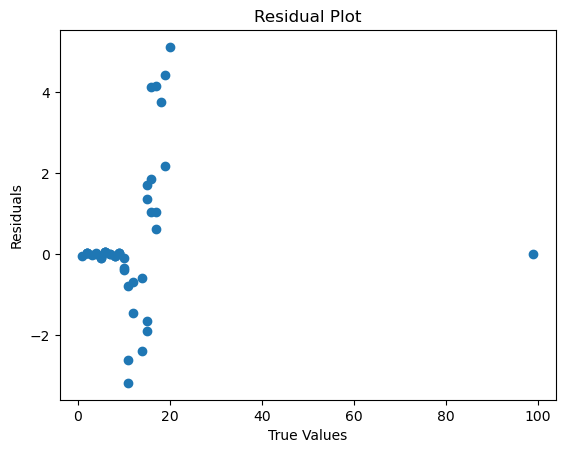

In [29]:
# Remove the identified outlier
outlier_index = 218
race_results_cleaned = race_results.drop(index=outlier_index)

# Redefine features and target variable
X_cleaned = race_results_cleaned.drop(columns=['position'])
y_cleaned = race_results_cleaned['position']

# Encode categorical variables (excluding track)
if not any(col.startswith('driver_') for col in X_cleaned.columns):
    X_cleaned = pd.get_dummies(X_cleaned, columns=['driver', 'team', 'set_fastest_lap'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Initialize and train the model with the best parameters found
best_model = RandomForestRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot residuals
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test - y_pred)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


Mean Squared Error: 2.9027746174570055
R^2 Score: 0.9846799280757095


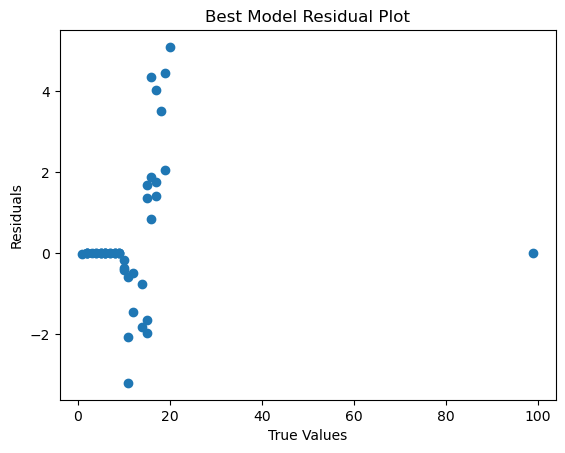

In [35]:
# Identify the specific outlier where the true value is 100
outlier_index = y_test[y_test == 100].index

# Remove the identified outlier from the dataset
race_results_cleaned = race_results_cleaned.drop(index=outlier_index)

# Redefine features and target variable
X_cleaned = race_results_cleaned.drop(columns=['position'])
y_cleaned = race_results_cleaned['position']

# Encode categorical variables
if not any(col.startswith('driver_') for col in X_cleaned.columns):
    X_cleaned = pd.get_dummies(X_cleaned, columns=['driver', 'team', 'set_fastest_lap'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Initialize and train the model with the best parameters found
best_model = RandomForestRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot residuals
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test - y_pred)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Best Model Residual Plot')
plt.show()


In [36]:
import joblib

# Save the model to a file
joblib.dump(best_model, 'race_result_predictor.pkl')

print("Model saved successfully!")

Model saved successfully!
